In [15]:
from linares_plot import *
import os
os.chdir('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model')
from model_ajustments import *


In [16]:
%load_ext autoreload
%autoreload 2

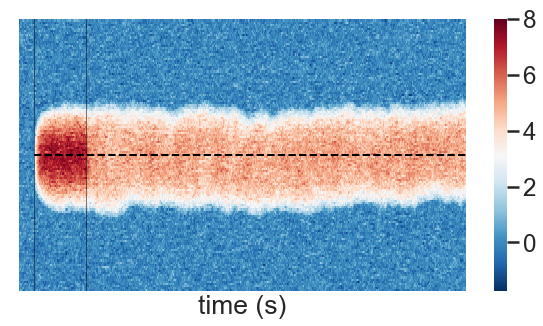

Simulation time: 21.3s
1 - with decode function
Gaussian fit


In [33]:
a1 = model(totalTime=3000, targ_onset=100,  presentation_period=350, angle_separation=22, tauE=9, tauI=4,  n_stims=1, 
     I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=225, kappa_I=15, 
     kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)

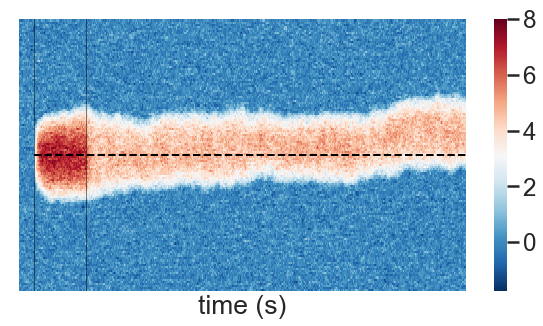

Simulation time: 18.8s
1 - with decode function
Gaussian fit


In [34]:
a2 = model(totalTime=3000, targ_onset=100,  presentation_period=350, angle_separation=22, tauE=9, tauI=4,  n_stims=1, 
     I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
     kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)

In [37]:
RE_3=a1[4]
RE_1=a2[4]

totalTime=3000
N=512
dt=2
targ_onset=100
presentation_period=350
nsteps=int(floor(totalTime/dt));
origin = np.pi
p_targ1 = int((N * np.degrees(origin ))/360)
p_targ2 = int((N * np.degrees(origin ))/360)
stimon = floor(targ_onset/dt);
stimoff = floor(targ_onset/dt) + floor(presentation_period/dt) ;

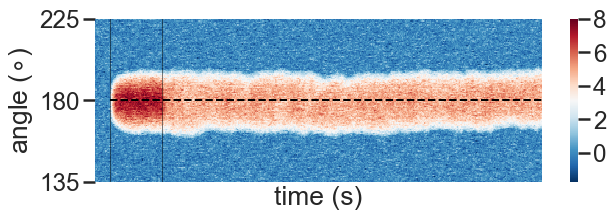

In [45]:
RE_sorted=flipud(RE_3)
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")
plt.figure(figsize=(10,3))
sns.heatmap(RE_sorted, cmap='RdBu_r', vmax=8)
plt.xlabel('time (s)')
plt.plot([stimon, nsteps], [p_targ2, p_targ2], '--k', linewidth=2) ## flipped, so it is p_target 
plt.yticks([])
plt.xticks([])
plt.yticks([3*N/8,   int(N/2),  5*N/8 ] ,['135', '180', '225'])
plt.ylim(int(3*N/8), int(5*N/8))
plt.ylabel(r'angle ($\circ$)')
plt.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
plt.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)
plt.show(block=False)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


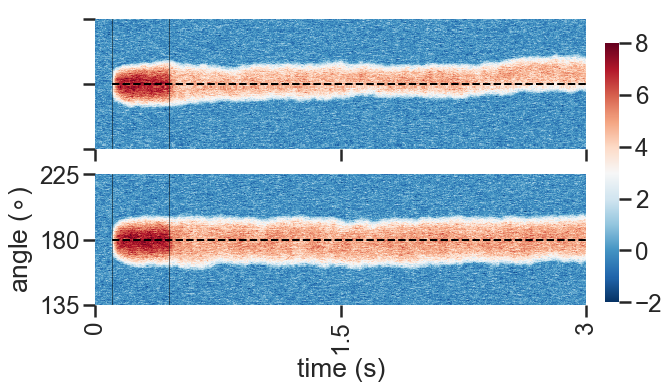

In [87]:

fig, axn = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 6))
cbar_ax = fig.add_axes([.87, .25, .02, .6])

RE_lst = [RE_1, RE_3]
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")

for i, ax in enumerate(axn.flat):
    RE_sorted=flipud(RE_lst[i])
    sns.heatmap(RE_sorted, ax=ax, cmap='RdBu_r', cbar=i == 0, vmax=8, vmin=-2, cbar_ax=None if i else cbar_ax)
    ax.set_ylim(int(3*N/8), int(5*N/8))
    ax.plot([stimon, nsteps], [p_targ2, p_targ2], '--k', linewidth=2) ## flipped, so it is p_target 
    if i==1:
        ax.set_xlabel('time (s)')
        ax.set_xticks([0, 750, 1500] )
        ax.set_xticklabels(['0', '1.5', '3'])
        ax.set_yticks([3*N/8,   int(N/2),  5*N/8 ])
        ax.set_yticklabels(['135', '180', '225'])
        ax.set_ylabel(r'angle ($\circ$)')
    elif i==0:
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_yticks([3*N/8,   int(N/2),  5*N/8 ])
        #ax.set_yticklabels(['', '', ''])
        #ax.set_xticks([])
        
    #
    ax.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
    ax.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)
    


fig.tight_layout(rect=[0, 0, .9, 1], h_pad=0.05)
#pad=1.08, h_pad=None, w_pad=None, rect=None

In [47]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.721889,0.602368,0.303023,0.757839,0.023359,0.020601,0.860065,0.908103,0.401580,0.511838
1,0.693925,0.048042,0.676225,0.279102,0.760450,0.285736,0.018122,0.022885,0.425411,0.852652
2,0.569930,0.723339,0.153115,0.030844,0.256082,0.930916,0.181679,0.985286,0.993381,0.218838
3,0.765627,0.104346,0.471435,0.665017,0.148783,0.275361,0.546553,0.150811,0.354523,0.885346
4,0.101936,0.940284,0.602386,0.944753,0.335443,0.521850,0.067579,0.971440,0.138287,0.332484
5,0.755389,0.306571,0.226870,0.435122,0.754645,0.589935,0.594131,0.767287,0.908195,0.376835
6,0.041695,0.446960,0.978865,0.722839,0.706017,0.525686,0.076975,0.641773,0.625348,0.797965
7,0.103113,0.543798,0.282786,0.144990,0.064166,0.893712,0.799830,0.764601,0.187663,0.771116
8,0.776961,0.628468,0.205936,0.575407,0.253288,0.601895,0.211288,0.108154,0.225026,0.971069
9,0.444079,0.079934,0.464852,0.196713,0.176790,0.748218,0.313613,0.215342,0.585207,0.474129


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


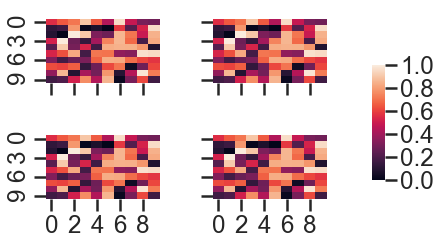

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.random((10,10,)))

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

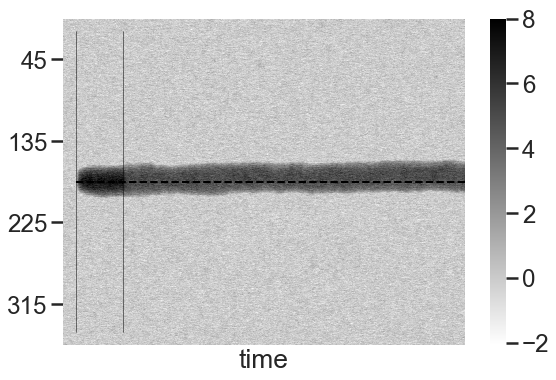

Simulation time: 10.8s
Gaussian fit


In [193]:
# m_225 = model(totalTime=3000, targ_onset=100,  presentation_period=350, angle_separation=22, tauE=9, tauI=4,  n_stims=1, 
#     I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=225, kappa_I=15, 
#     kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)

# current_225 = np.mean(m_225[4][:, -1000:], axis=1)


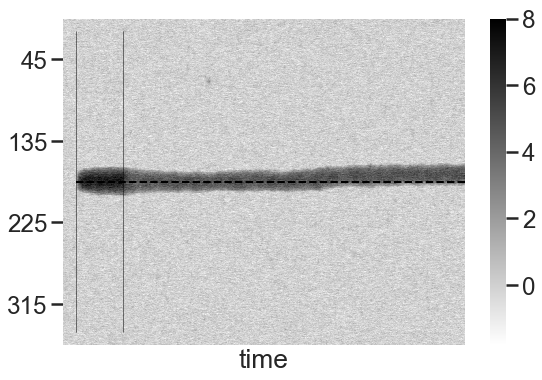

Simulation time: 10.9s
Gaussian fit


In [194]:
# m_300 = model(totalTime=3000, targ_onset=100,  presentation_period=350, angle_separation=22, tauE=9, tauI=4,  n_stims=1, 
#     I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
#     kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)

# current_300 = np.mean(m_300[4][:, -1000:], axis=1)

In [348]:
####np.savetxt('current_225.txt', current_225)
####np.savetxt('current_300.txt', current_300)
current_255 = np.loadtxt('current_225.txt')
current_300 = np.loadtxt('current_300.txt')

In [233]:
sep_deg=23
sep_neurons = sep_deg*len(current_225)/360

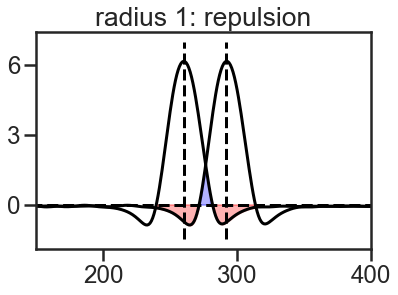

In [350]:
static = current_300
displaced= np.roll(current_300, int(sep_neurons))
x=np.linspace(0,N-1,N)


plt.plot(static, 'k')
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--')
plt.plot(displaced, 'k'   )
plt.plot([0,512], [0,0], 'k--')
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--')
plt.xlim(150,400)
plt.yticks([0, 3, 6])
plt.title('radius 1: repulsion')

stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[13:16]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()


ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color="red", alpha=0.3)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color="red", alpha=0.3)
plt.fill_between(x,displaced, ref, color="blue", where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.3)
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)




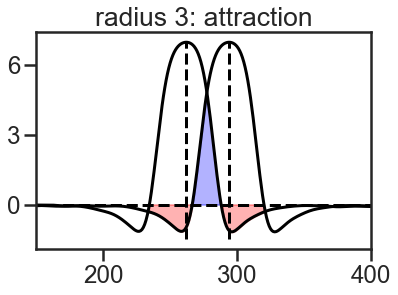

In [349]:
static = current_225
displaced= np.roll(current_225, int(sep_neurons))
x=np.linspace(0,N-1,N)


plt.plot(static, 'k')
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--')
plt.plot(displaced, 'k'   )
plt.plot([0,512], [0,0], 'k--')
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--')
plt.xlim(150,400)
plt.yticks([0, 3, 6])
plt.title('radius 3: attraction')

stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[5:8]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()


ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color="red", alpha=0.3)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color="red", alpha=0.3)
plt.fill_between(x,displaced, ref, color="blue", where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.3)
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)




In [352]:

def model(totalTime, targ_onset, presentation_period, angle_separation, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.022, GEI=0.019, 
 GIE=0.01 , GII=0.1, sigE=0.5, sigI=1.6, kappa_E=100, kappa_I=1.75, kappa_stim=100, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=True):
    #
    st_sim =time.time()
    dt=2
    nsteps=int(floor(totalTime/dt));
    origin = pi
    rE=zeros((N,1));
    rI=zeros((N,1));
    #Connectivities
    v_E=zeros((N));
    v_I=zeros((N));
    WE=zeros((N,N));
    WI=zeros((N,N));
    separation =  angle_separation*pi/360
    angle_target=180+angle_separation/2
    angle_distractor=180-angle_separation/2
    if n_stims==1:
        separation=0


    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) for f in range(0, len(theta))]
        ###    
        vE_NEW=roll(v_E_new,i)
        vI_NEW=roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    #
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.show(block=False)
    ##
    # Stims
    if n_stims==2:
        stimulus1=zeros((N))
        stimulus2=zeros((N))
        for i in range(0, N):
            stimulus1[i]=e**(kappa_stim*cos(theta[i] + origin - separation)) / (2*pi*scipy.special.i0(kappa_stim))
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin + separation)) / (2*pi*scipy.special.i0(kappa_stim))
        stimulus= (stimulus1 + stimulus2);
        stimulus=reshape(stimulus, (N,1))
    elif n_stims==1:
        stimulus2=zeros((N));
        for i in range(0, N):
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin)) / (2*pi*scipy.special.i0(kappa_stim))
        stimulus=stimulus2
        stimulus=reshape(stimulus, (N,1))
    ###
    ###
    stimon = floor(targ_onset/dt);
    stimoff = floor(targ_onset/dt) + floor(presentation_period/dt) ;
    #Simulation
    #generation of the noise and the connectivity between inhib and exit
    RE=zeros((N,nsteps));
    RI=zeros((N,nsteps));
    IEs= zeros((N,nsteps));
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);
        #differential equations for connectivity
        IE= GEE*dot(WE,rE) - GIE*dot(WI,rI) + I0E*ones((N,1));
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
        #
        if i>stimon and i<stimoff:
            IE=IE+stimulus;
            II=II+stimulus;
        #
        #rates of exit and inhib
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        rEr=reshape(rE, N)
        rIr=reshape(rI, N)
        #drawnow
        RE[:,i] = rEr;
        RI[:,i] = rIr;
        IEs[:,i] = reshape(IE,N)
    #
    ## metrics
    if n_stims==2:
        interference = Interference_effects( [decode_rE(stimulus1)], [decode_rE(rE)], [decode_rE(stimulus2)])[0]

    p_targ1 = int((N * np.degrees(origin + separation))/360)
    p_targ2 = int((N * np.degrees(origin - separation))/360)
    #
    if plot_rate==True:
        #### plot dynamics
        fig = plt.figure()
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ1, :], 'b', label='target1')
        plt.plot(RE[p_targ2, :], 'r', label='target2')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    if plot_hm==True:
        #### plot heatmap
        RE_sorted=flipud(RE)
        plt.figure(figsize=(9,6))
        sns.heatmap(RE_sorted, cmap='binary', vmax=8)
        #plt.title('BUMP activity')
        #plt.ylabel('Angle')
        plt.xlabel('time')
        plt.plot([stimon, nsteps], [p_targ2, p_targ2], '--k', linewidth=2) ## flipped, so it is p_target 
        #plt.plot([stimon, nsteps], [p_targ1, p_targ1], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        #plt.plot([stimon, stimon,], [0+20, N-20], 'k-', label='onset')
        #plt.plot([stimoff, stimoff,], [0+20, N-20], 'k--', label='offset')
        plt.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
        plt.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)
        #plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')

    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    def gauss(x,mu,sigma,A):
        return A*exp(-(x-mu)**2/2/sigma**2)

    std_g = 999
    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)

    ### Fit
    #df_n_p=pd.DataFrame()
    #df_n_p['rE'] = rE.reshape(512)
    #r = df_n_p['rE'].rolling(window=20).mean()
    #number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 

    if number_of_bumps ==2:
        param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75], maxfev=10000)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angle_1=np.degrees(param[0]+pi)  
        estimated_angle_2=np.degrees(param[2]+pi)  
        estimated_angles = [estimated_angle_1, estimated_angle_2]
        estimated_angles.sort()
        bias_b1 = estimated_angles[0] -  np.degrees(origin - separation) ### change the error stuff
        bias_b2 =  np.degrees(origin + separation) - estimated_angles[1]
        final_bias = [bias_b1, bias_b2]
        skip_r_sq=False
        success=True
        decode_func = 0
        if n_stims==1:
            print('Error simultaion')
            bias_b1=999
            bias_b2=999
            estimated_angles=999
            final_bias=[999, 999]
            plot_fit=False
            skip_r_sq=True
            r_squared=0
            success=False ## to eliminate wrong simulations easily at the end
            decode_func = 0
        #
    #
    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y, maxfev=10000)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        if param[0]<0:
            estimated_angles =decode_rE(rE)
            print('1 - with decode function')
            decode_func = 1
        else:
            estimated_angles=np.degrees(param[0]+pi) 
            decode_func = 0 
        #
        bias_b1 = estimated_angles - np.degrees( origin - separation)
        bias_b2 = np.degrees(origin + separation) - estimated_angles  ## bias (positive means attraction)
        ###final_bias = [bias_b1, bias_b2]  
        final_bias = [bias_b1, bias_b2] # de la otra manera estas forzando la media todo el rato
        skip_r_sq=False
        success=True
        print('Gaussian fit')
        param_g, covs_g = curve_fit(gauss, X, y, maxfev=10000)
        std_g = param_g[1]




        if n_stims==1:
            estimated_angles=np.degrees(param[0]+pi)
            bias_b1 = np.degrees(origin) - estimated_angles ## con fit
            bias_b2 = 180 - decode_rE(rE) ## scon decode_rE
            final_bias = [abs(bias_b2), abs(bias_b2)]
    ##
    else:
        print('Error simultaion')
        bias_b1=999
        bias_b2=decode_rE(rE)
        estimated_angles=999
        final_bias=[999, 999]
        plot_fit=False
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end
        decode_func = 0

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    ##
    ### Output
    total_sep=np.degrees(2*separation)
    final_bias = np.mean(final_bias)
    #print(total_sep)
    return(IE, WE, WI, rE, IEs, final_bias, bias_b1, bias_b2, rE, RE, estimated_angles, total_sep, kappa_E, kappa_I, r_squared, success, number_of_bumps, decode_func, std_g) #bias_b1, bias_b2)


###